In [3]:
import numpy as np
import random
from random import sample
import scipy as sp
from scipy.stats import qmc
import matplotlib.pyplot as plt

In [4]:
def is_mandelbrot(c,max_recursion):
    '''
    A function that checks if a number is inside the Mandelbrot set.

    Args:
    c - complex number
    max_recursion - maximum checks whether the complex number is
                    is inside the Mandelbrot set.
    '''
    counter=0
    threshold=2
    Z_now=complex(0,0)
    while(counter<max_recursion):
        Z_next=pow(Z_now,2)+c
        if(abs(Z_next)>threshold):
            return counter
        Z_now=Z_next
        # return the iteration when the number escaped
        counter+=1
    return max_recursion

def point_counter(x,y,max_recursion):
    '''
    A function to count the number of points inside the Mandelbrot set,
    which are coming from a sample pool.

    Args:
    x - coordinates of the point
    y - coordinates of the point
    max_recursion - the number of times we want to observe the progression of the number
    '''
    counter=0
    for i,x_i in enumerate(x):
        c=complex(x_i,y[i])
        check=is_mandelbrot(c,max_recursion)
        if check==max_recursion : counter+=1
    return counter

def create_grid(x,y,max_recursion):
    '''
    TO DO: ADD DOCUMENTATION
    '''
    X,Y=np.meshgrid(x,y)
    C=np.vectorize(complex)(X,Y)
    Z=[]
    for row in C:
        Z_row=[]
        for c in row:
            Z_row.append(is_mandelbrot(c,max_recursion))
        Z.append(Z_row)
    Z=np.array(Z)
    return Z


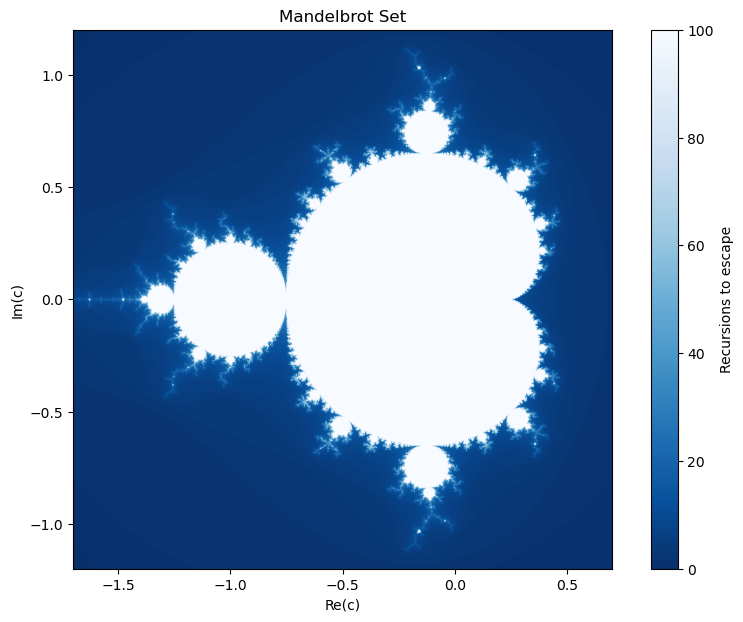

In [95]:
def plot_fractal(Z,x1,x2,y1,y2):
    plt.figure(figsize=(10,7))
    plt.imshow(Z,extent=(x1,x2,y1,y2),cmap='Blues_r',interpolation='bilinear')
    plt.colorbar(label='Recursions to escape')
    plt.title('Mandelbrot Set')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.show()

max_iters=100
n=1000
x=np.linspace(-1.7,0.7,n)
y=np.linspace(-1.2,1.2,n)
plot_fractal(create_grid(x,y,max_iters),min(x),max(x),min(y),max(y))

In [ ]:
def PR_area_estimate(x_range, y_range, max_iters, num_samples):
    '''
    Estimates area of Mandelbrot set using Pure Random Sampling method

    Args:
    x_range: range of the x coordinates
    y_range: range of the y coordinates
    max_recursion: the number of times we want to observe the progression of the number
    num_samples: number of samples to be taken

    Returns:
    estimated_area: the estimated area of the Mandelbrot set
    '''
    # Samples points from random uniform distribution
    x_samples = np.random.uniform(x_range[0], x_range[1], num_samples)
    y_samples = np.random.uniform(y_range[0], y_range[1], num_samples)

    # Calculates area based on ratio of points in set respective to total area of bounds
    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples
    return estimated_area

def LHS_area_estimate(x_range, y_range, max_iters, num_samples):
    '''
    Estimates area of Mandelbrot set using Latin Hypercube sampling method

    Args:
    x_range: range of the x coordinates
    y_range: range of the y coordinates
    max_iters: the number of times we want to observe the progression of the number
    num_samples: number of samples to be taken

    Returns:
    estimated_area: the estimated area of the Mandelbrot set
    '''
    # LHS method from qmc library
    sample_set = qmc.LatinHypercube(d=2)
    sample = sample_set.random(n=num_samples)

    # Scales LHS samples to Mandelbrot set bounds
    x_samples = x_range[0] + sample[:, 0] * (x_range[1] - x_range[0])
    y_samples = y_range[0] + sample[:, 1] * (y_range[1] - y_range[0])


    # Counts if sample points are in Mandelbrot and calculates area
    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples

    return estimated_area

def ortho_area_estimate(x_range, y_range, max_iters, num_samples, sub_sections):

    '''
    Estimates area of Mandelbrot set using Latin Hypercube sampling method

    Args:
    x_range: range of the x coordinates
    y_range: range of the y coordinates
    max_iterations: the number of times we want to observe the progression of the number
    num_samples: number of total samples to be taken
    sub_sections: number of subsections to divide the area into

    Returns:
    estimated_area: the estimated area of the Mandelbrot set
    '''

    # Number of samples per subsection
    samples_per_section = num_samples // (sub_sections * sub_sections)

    # Defines boundaries of the subsections on both axes
    x_size = np.linspace(x_range[0], x_range[1], sub_sections + 1)
    y_size = np.linspace(y_range[0], y_range[1], sub_sections + 1)

    x_samples = []
    y_samples = []

    for i in range(sub_sections):
        for j in range(sub_sections):

            # Latin hypercube for each sub section
            sample_set = qmc.LatinHypercube(d=2)
            cell_samples = sample_set.random(n=samples_per_section)

            # Min and max of y values
            x_cell_min, x_cell_max = x_size[i], x_size[i + 1]
            y_cell_min, y_cell_max = y_size[j], y_size[j + 1]

            # Scales samples to be between 0 and 1 for LHS
            x_cell_samples = x_cell_min + cell_samples[:, 0] * (x_cell_max - x_cell_min)
            y_cell_samples = y_cell_min + cell_samples[:, 1] * (y_cell_max - y_cell_min)

            # Adds scaled points to sample arrays
            x_samples.extend(x_cell_samples)
            y_samples.extend(y_cell_samples)

    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)

    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples

    return estimated_area


In [6]:
def run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations, sub_sections):
    """
    Runs multiple simulations for the given max iterations, n samples, and type of sampling method.
    Returns the average area estimate from the simulations.
    """
    areas = []
    
    for _ in range(num_simulations):
        if sample_type == "Pure Random":
            est_area = PR_area_estimate(x_range, y_range, max_iters, n)
        elif sample_type == "Latin Hypercube":
            est_area = LHS_area_estimate(x_range, y_range, max_iters, n)
        else:
            est_area = ortho_area_estimate(x_range, y_range, max_iters, n, sub_sections)

        areas.append(est_area)
    
    return np.mean(areas), np.std(areas)


In [ ]:
def run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations, sub_sections):
    """
    Runs multiple simulations for the given max iterations, n samples, and type of sampling method.
    Returns the average area estimate from the simulations.

    Args:
    x_range: range of the x coordinates
    y_range: range of the y coordinates
    max_iters: the number of times we want to observe the progression of the number
    n: number of samples to be taken
    sample_type: the sampling method (string)
    num_simulations: number of simulations to be run
    sub_sections: number of subsections to divide the area into

    Returns:
    np.mean(areas): the average area estimate from the simulations
    np.std(areas): the standard deviation of the area estimates
    """
    areas = []

    for _ in range(num_simulations):
        if sample_type == "Pure Random":
            est_area = PR_area_estimate(x_range, y_range, max_iters, n)
        elif sample_type == "Latin Hypercube":
            est_area = LHS_area_estimate(x_range, y_range, max_iters, n)
        else:
            est_area = ortho_area_estimate(x_range, y_range, max_iters, n, sub_sections)

        areas.append(est_area)

    return np.mean(areas), np.std(areas)

def plot_areas_convergence(x_range, y_range, n_list, max_iters_range, num_simulations, sub_sections):
    """
    Plots the convergence of the area estimates with respect to increasing sample sizes and iterations.
    Runs multiple simulations for each combination of iterations and samples for three sampling types.

    Args:
    x_range: range of the x coordinates
    y_range: range of the y coordinates
    n_list: list of sample sizes to be tested
    max_iters_range: list of max iterations
    num_simulations: number of simulations to be run
    sub_sections: number of subsections to divide the area into

    Returns: Plots the convergence of the area estimates.
    """
    sampling_types = ["Pure Random", "Latin Hypercube", "Orthogonal"]
    area_results = {sample_type: {} for sample_type in sampling_types}
    print("Means and Errors of A(i,s):")

    # Run simulations for all sampling methods
    for sample_type in sampling_types:
        for max_iters in max_iters_range:
            areas = []
            area_diffs = []
            errors = []

            print(f"\nMax Iterations i = {max_iters}, Sampling Method = {sample_type}")

            for n in n_list:
                avg_area, st_dev = run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations, sub_sections)
                areas.append(avg_area)
                RMSE = st_dev / np.sqrt(num_simulations)
                errors.append(RMSE)

                print(f"  Sample Size (s = {n}): Mean A(i,s) = {avg_area:.4f}, RMSE = {RMSE:.4f}")

            final_area = areas[-1] # Last area/iteration combination, assumed to be optimal
            for area in areas[:-1]:
                diff = abs(area - final_area)
                area_diffs.append(diff)

            area_results[sample_type][max_iters] = (area_diffs, errors[:-1], areas)

    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    colors = plt.cm.viridis(np.linspace(0, 1, len(max_iters_range)))

    # Plot 1: Convergence (A(j,s) - A(i,s))
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (diffs, errs, _)) in enumerate(area_results[sample_type].items()):
            axs[0, i].errorbar(n_list[:-1], diffs, yerr=errs, label=f"Max Iter = {max_iters}", color=colors[j], capsize=3, marker='o', linestyle='-', linewidth=2)
        axs[0, i].set_title(f'Convergence of A(j,s) - A(i,s) ({sample_type})')
        axs[0, i].set_xlabel("Sample Size (s)")
        axs[0, i].set_ylabel("Difference A(j,s) - A(i,s)")
        axs[0, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[0, i].legend(fontsize=10)

    # Plot 2: Stabilization of Area Estimates (A(i,s))
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (_, _, areas)) in enumerate(area_results[sample_type].items()):
            axs[1, i].plot(n_list, areas, label=f"Max Iter = {max_iters}", color=colors[j], marker='x', linestyle='-', linewidth=2)
        axs[1, i].set_title(f'Stabilization of Area Estimates A(i,s) ({sample_type})')
        axs[1, i].set_xlabel("Sample Size (s)")
        axs[1, i].set_ylabel("Area Estimate A(i,s)")
        axs[1, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[1, i].legend(fontsize=10)

    # Plot 3: Stabilization of RMSE
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (_, errs, _)) in enumerate(area_results[sample_type].items()):
            axs[2, i].plot(n_list[:-1], errs, label=f"Max Iter = {max_iters}", color=colors[j], marker='s', linestyle='-', linewidth=2)
        axs[2, i].set_title(f'Stabilization of RMSE ({sample_type})')
        axs[2, i].set_xlabel("Sample Size (s)")
        axs[2, i].set_ylabel("RMSE")
        axs[2, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[2, i].legend(fontsize=10)

    plt.tight_layout()
    plt.show()


In [8]:
x_range = (-1.7,0.7)
y_range = (-1.7,1.2)
max_iters_range = [100, 500, 1000, 5000, 7000, 10000]
n_list = [1000, 5000, 10000, 50000, 70000, 100000]
num_simulations = 10
sub_sections = 5

plot_areas_convergence(x_range, y_range, n_list, max_iters_range, num_simulations, sub_sections)

Means and Errors of A(i,s):

Sample Size s = 1000, Sampling Method = Pure Random
  Max Iterations (i = 100): Mean A(i,s) = 1.6328, RMSE = 0.0283
  Max Iterations (i = 500): Mean A(i,s) = 1.4992, RMSE = 0.0293
  Max Iterations (i = 1000): Mean A(i,s) = 1.5347, RMSE = 0.0352
  Max Iterations (i = 5000): Mean A(i,s) = 1.5298, RMSE = 0.0288
  Max Iterations (i = 7000): Mean A(i,s) = 1.4901, RMSE = 0.0278
  Max Iterations (i = 10000): Mean A(i,s) = 1.4971, RMSE = 0.0277

Sample Size s = 5000, Sampling Method = Pure Random
  Max Iterations (i = 100): Mean A(i,s) = 1.5432, RMSE = 0.0153
  Max Iterations (i = 500): Mean A(i,s) = 1.5039, RMSE = 0.0097
  Max Iterations (i = 1000): Mean A(i,s) = 1.5110, RMSE = 0.0068
  Max Iterations (i = 5000): Mean A(i,s) = 1.5142, RMSE = 0.0086
  Max Iterations (i = 7000): Mean A(i,s) = 1.5092, RMSE = 0.0153
  Max Iterations (i = 10000): Mean A(i,s) = 1.5185, RMSE = 0.0094

Sample Size s = 10000, Sampling Method = Pure Random
  Max Iterations (i = 100): Mean A

KeyboardInterrupt: 

a=[1.5474216000000192, 1.5252128000000191, 1.5197184000000197, 1.516930400000019, 1.5150264000000186, 1.5138024000000188, 1.5132176000000175, 1.5110824000000194, 1.5112456000000174, 1.5092464000000207, 1.508607200000017, 1.5089472000000184, 1.5077912000000189, 1.5093824000000209, 1.509572800000019, 1.5087568000000193, 1.508090400000019, 1.5087432000000198, 1.5089608000000199, 1.5087704000000186, 1.5081312000000189, 1.5074104000000186, 1.5078864000000185, 1.5069616000000177, 1.5080904000000184, 1.5081040000000194, 1.5070024000000193, 1.5083760000000195, 1.5080496000000185, 1.5075328000000197, 1.5064176000000182, 1.5085936000000193, 1.5076824000000193, 1.5086344000000187, 1.5084848000000175, 1.5072744000000187, 1.507206400000019, 1.5081448000000188, 1.5076688000000193, 1.5074784000000185, 1.5081584000000197, 1.5063496000000192, 1.507328800000019, 1.508158400000019, 1.5066080000000177, 1.50713840000002, 1.5095592000000198, 1.5064040000000183, 1.5061184000000185, 1.5074376000000196, 1.5086072000000195, 1.5070568000000186, 1.506268000000019, 1.5070296000000187, 1.5072200000000202, 1.5064856000000193]